# 0. Libraries and Dependencies

In [ ]:
!pip install pycuda
!pip install cython

In [1]:
import numpy as np
import pandas as pd
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import driver, compiler, gpuarray, tools
import numpy as np
from scipy.sparse import coo_matrix
import scipy.sparse
from scipy.sparse import coo_matrix
import scipy.sparse.csgraph
from timeit import Timer
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import time
import multiprocessing


# 1. Generates a Random Graph

In [2]:
def generate_connected_graph(n_nodes, min_conn_per_node): 
    """
    Generates a connected graph with a specified number of nodes and minimum number of connections per node using a random algorithm.

    Parameters:
        n_nodes (int): The number of nodes in the graph.
        min_conn_per_node (int): The minimum number of connections per node.

    Returns:
        scipy.sparse.coo_matrix: The adjacency matrix of the generated graph in COO format.
    """


    # Initialize graph with all nodes having one connection (i.e., self-connection)
    graph = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        graph[i, i] = 1

    # Establishes additional connections
    while True:
        # Check if all nodes have minimum number of connections
        if (graph.sum(axis=1) >= min_conn_per_node).all():
            break

        # Randomly select a node with fewer than minimum number of connections
        node = np.random.choice(np.where(graph.sum(axis=1) < min_conn_per_node)[0])

        # Create connections until minimum number of connections is reached
        while graph[node].sum() < min_conn_per_node:
            # Randomly select a node to connect to
            connect_to = np.random.randint(0, n_nodes)

            # Check if nodes are already connected
            if graph[node, connect_to] == 1 or graph[connect_to, node] == 1:
                continue

            # Add connection between nodes
            graph[node, connect_to] = 1
            graph[connect_to, node] = 1

    # Convert graph to COO format
    coo = scipy.sparse.coo_matrix(graph)
    
    return coo




In [ ]:
# n_nodes = 500
# min_conn_per_node = 20
# graph_coo = generate_connected_graph(n_nodes, min_conn_per_node)

# # # Select a random node
# node = np.random.randint(0, n_nodes)
# # Check the number of edges for this node
# print(f"Number of edges for node {node}: {graph_coo.getrow(node).sum()}")

# 2. NumPy/Naive Implementation of PageRank

In [3]:
def pagerank_numpy(graph_coo, max_iter, tol):
    """
    Computes the PageRank score of each node in the graph using NumPy.

    Parameters:
    graph_coo (scipy.sparse.coo_matrix): The adjacency matrix of the graph in COO format.
    max_iter (int): The maximum number of iterations. Default is 100.
    tol (float): The tolerance for convergence. Default is 1e-6.

    Returns:
    numpy.ndarray: The PageRank scores of each node in the graph.
    """

    # Convert COO matrix to CSR matrix
    graph_csr = graph_coo.tocsr()
    N = graph_csr.shape[0]

    # Calculate the out-degree for each node
    out_degree = graph_csr.sum(axis=1).A.ravel().astype(np.float32)

    # Initialize the PageRank score for each node
    x = np.full(N, 1/N, dtype=np.float32)

    # Run the PageRank algorithm
    damping_factor = 0.85
    for _ in range(max_iter):
        prev_x = x.copy()
        for i in range(N):
            sum = 0.0
            for j in range(graph_csr.indptr[i], graph_csr.indptr[i+1]):
                col = graph_csr.indices[j]
                sum += graph_csr.data[j] * prev_x[col] / out_degree[col]
            x[i] = damping_factor * sum + (1 - damping_factor) / N
        if np.abs(prev_x - x).max() < tol:
            break

    return x

# 3. Parallel Implementation on CPU (Cython)

In [ ]:
%load_ext Cython

In [ ]:
%%cython --cplus

import numpy as np
import scipy.sparse as sp
from joblib import Parallel, delayed
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def pagerank_step(int i, int[:] indptr, int[:] indices, double[:] data, double[:] prev_x, double[:] out_degree, double damping_factor, int N):
    cdef:
        int j, col
        double sum = 0.0
    for j in range(indptr[i], indptr[i+1]):
        col = indices[j]
        sum += data[j] * prev_x[col] / out_degree[col]
    return damping_factor * sum + (1 - damping_factor) / N

def pagerank_cython(graph_coo, max_iter=100, tol=1e-6, num_threads=-1):
    """
    Computes the PageRank score of each node in the graph using with parallelization using CPU threads.

    Parameters:
        graph_coo (scipy.sparse.coo_matrix): The adjacency matrix of the graph in COO format.
        max_iter (int): The maximum number of iterations. Default is 100.
        tol (float): The tolerance for convergence. Default is 1e-6.
        num_threads (int): The number of threads to use for parallelization. Default is the number of CPU cores.

    Returns:
        numpy.ndarray: The PageRank scores of each node in the graph.
    """
    # Convert COO matrix to CSR matrix
    graph_csr = graph_coo.tocsr()
    cdef int N = graph_csr.shape[0]

    # Calculate the out-degree for each node
    out_degree = graph_csr.sum(axis=1).A.ravel().astype(np.float64)

    # Initialize the PageRank score for each node
    x = np.full(N, 1/N, dtype=np.float64)

    # Run the PageRank algorithm
    cdef double damping_factor = 0.85
    cdef int iter_num
    if num_threads < 1:
        num_threads = None
    with Parallel(n_jobs=num_threads) as parallel:
        for iter_num in range(max_iter):
            prev_x = x.copy()
            results = parallel(delayed(pagerank_step)(i, graph_csr.indptr, graph_csr.indices, graph_csr.data, prev_x, out_degree, damping_factor, N) for i in range(N))
            x = np.array(results)
            if np.abs(prev_x - x).max() < tol:
                break
    x_sum = x.sum()
    if x_sum > 0:
        x /= x_sum
    return x



# 4. Parallel Implementation on GPU (PyCUDA)

In [4]:
def pagerank_gpu(graph, max_iter, tol):
    """
    Computes the PageRank score of each node in the graph with GPU parallelization using PyCUDA.

    Parameters:
    graph (scipy.sparse.csr_matrix): The adjacency matrix of the graph in CSR format.
    max_iter (int): The maximum number of iterations. Default is 1000.
    tol (float): The tolerance for convergence. Default is 1e-6.

    Returns:
    numpy.ndarray: The PageRank scores of each node in the graph.
    """

    # Convert the graph to the CSR format
    graph = graph.tocsr()
    N = graph.shape[0]
    edges = graph.indices.astype(np.int32)
    indptr = graph.indptr.astype(np.int32)
    out_degree = np.diff(indptr).astype(np.int32)
    pagerank = np.ones(N, dtype=np.float32) / N
    damping_factor = 0.85
    teleport_probability = (1.0 - damping_factor) / N

    # Find dangling nodes
    dangling_nodes = np.where(out_degree == 0)[0]
    dangling_rank = np.sum(pagerank[dangling_nodes])

    # Define the pagerank kernel
    pagerank_kernel_code = """
        __global__ void pagerank_kernel(float *pagerank, const int *edges, const int *indptr, const int *out_degree, const float damping_factor, const float teleport_probability, const float dangling_rank)
        {
            const int i = blockIdx.x * blockDim.x + threadIdx.x;
            const int N = %(N)s;
            const float one_minus_damping = 1.0f - damping_factor;

            if (i < N) {
                float sum = 0.0f;
                for (int j = indptr[i]; j < indptr[i+1]; j++) {
                    const int neighbor = edges[j];
                    const int neighbor_degree = out_degree[neighbor];
                    sum += pagerank[neighbor] / neighbor_degree;
                }
                pagerank[i] = one_minus_damping * teleport_probability + damping_factor * sum + one_minus_damping * dangling_rank / N;
            }
        }
    """ % {"N": N}
    pagerank_kernel = SourceModule(pagerank_kernel_code).get_function("pagerank_kernel")

    # Run the pagerank algorithm
    last_pagerank = np.zeros(N, dtype=np.float32)
    for i in range(max_iter):
        pagerank_kernel(cuda.InOut(pagerank), cuda.In(edges), cuda.In(indptr), cuda.In(out_degree), np.float32(damping_factor), np.float32(teleport_probability), np.float32(dangling_rank), block=(128, 1, 1), grid=((N + 127) // 128, 1, 1))
        cuda.Context.synchronize()
        if np.linalg.norm(pagerank - last_pagerank, np.inf) < tol:
            break
            
        last_pagerank[:] = pagerank
        
    # Normalize the pagerank vector to sum up to 1
    pagerank /= np.sum(pagerank)

    return pagerank


# 5. Results

## 5.1 Hyperparametter Setting

In [22]:
max_iter = 100
tol = 1.0e-6
num_threads=-1

## 5.2 Comparison of results

In [24]:
def compute_pagerank_times(node_list, conn_list, max_iter, tol, num_threads):

    """
    Computes the PageRank score of each node in the graph using NumPy with CPU parallelization.

    Parameters:
    node_list (list): A list of integers specifying the number of nodes in each graph.
    conn_list (list): A list of integers specifying the minimum number of connections per node in each graph.
    max_iter (int): The maximum number of iterations. Default is 100.
    tol (float): The tolerance for convergence. Default is 1e-6.

    Returns:
    pandas.DataFrame: A DataFrame containing the results of the PageRank computation for each graph. The DataFrame
    has the following columns:
    - num_nodes (int): The number of nodes in the graph.
    - min_conn_per_node (int): The minimum number of connections per node in the graph.
    - numpy_time: The time taken to compute the PageRank score using the numPy/naive implementation.
    - cpu_time (float): The time taken to compute the PageRank score using the parallelized CPU implementation.
    - gpu_time (float): The time taken to compute the PageRank score using the parallelized GPU implementation.
    """

    df = pd.DataFrame(columns=['num_nodes', 'min_conn_per_node', 'numpy_time', 'cpu_time', 'gpu_time', 'MSE'])
    
    for i, n_nodes in enumerate(node_list):
        min_conn_per_node = conn_list[i]
        
        # Generate a sparse graph
        graph_coo = generate_connected_graph(n_nodes=n_nodes, min_conn_per_node=min_conn_per_node)
        
        # Compute the PageRank using the NumPy implementation
        start_time = time.time()
        pagerank_scores1 = pagerank_numpy(graph_coo, max_iter, tol)
        numpy_time = time.time() - start_time
        
        # Compute the PageRank using the CPU implementation
        start_time = time.time()
        pagerank_scores2 = pagerank_cython(graph_coo, max_iter, tol, num_threads)
        cpu_time = time.time() - start_time
        
        # Compute the PageRank using the GPU implementation
        start_time = time.time()
        pagerank_scores3 = pagerank_gpu(graph_coo, max_iter, tol)
        gpu_time = time.time() - start_time
        
        # mse = ((pagerank_scores1 - pagerank_scores3) ** 2).mean()
        
        row_dict = {'num_nodes': n_nodes,
                    'min_conn_per_node': min_conn_per_node,
                    'numpy_time': numpy_time,
                    'cpu_time': cpu_time,
                    'gpu_time': gpu_time,
                    # 'MSE': mse
                   }
        df = pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)
        
    return df

In [25]:
nodes_list = [1000, 2000, 4000, 6000, 8000, 10000]
min_conn_list = [100, 200, 400, 600, 800, 1000]
times_df= compute_pagerank_times(nodes_list, min_conn_list, max_iter, tol, num_threads)

In [28]:
# import pickle
# with open('times_df3.pkl', 'wb') as handle:
#     pickle.dump(times_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
def plot_pagerank_times(df):
    """
    Plots the PageRank computation time for different implementations.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing the computation times for each implementation.

    Returns:
    None
    """
    fig, ax = plt.subplots()

    # Plot the GPU time
    df.plot(x='num_nodes', y='gpu_time', ax=ax, label='GPU', color='lightseagreen')

    # Plot the NumPy time
    df.plot(x='num_nodes', y='numpy_time', ax=ax, label='NumPy', color='lightcoral')

    # Plot the CPU time
    df.plot(x='num_nodes', y='cpu_time', ax=ax, label='CPU', color='forestgreen')

    # Set the title and axis labels
    ax.set_title('PageRank computation time')
    ax.set_xlabel('Number of nodes')
    ax.set_ylabel('Time (seconds)')

    # Display the legend
    ax.legend()

    # # Show the plot
    plt.show()


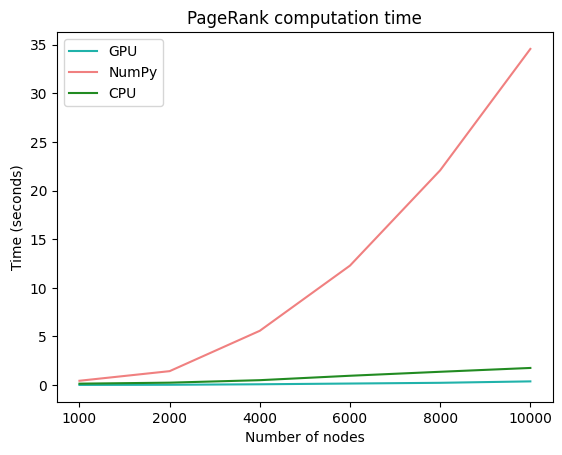

In [32]:
plot_pagerank_times(times_df)